<a href="https://colab.research.google.com/github/abidur0177/Natural_Language_Processing/blob/main/Sentiment_classification_multilayer_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In this project, I will classify the sentiment of IMDB reviews using a multi-layer LSTM architecture. The dataset that will be used is subword encoded tokenised dataset from imdb reviews.

### Import necessary libraries and the dataset

In [4]:
import tensorflow_datasets as tfds

# Download the dataset
dataset, info = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteSXJ8HH/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteSXJ8HH/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incompleteSXJ8HH/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


In [5]:
# Observe the info of the dataset
info

tfds.core.DatasetInfo(
    name='imdb_reviews',
    full_name='imdb_reviews/subwords8k/1.0.0',
    description="""
    Large Movie Review Dataset. This is a dataset for binary sentiment
    classification containing substantially more data than previous benchmark
    datasets. We provide a set of 25,000 highly polar movie reviews for training,
    and 25,000 for testing. There is additional unlabeled data for use as well.
    """,
    config_description="""
    Uses `tfds.deprecated.text.SubwordTextEncoder` with 8k vocab size
    """,
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    data_dir=PosixGPath('/tmp/tmpsy2m3apqtfds'),
    file_format=tfrecord,
    download_size=80.23 MiB,
    dataset_size=54.72 MiB,
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
        'text': Text(shape=(None,), dtype=int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    supervised_keys=('text', 'label'),
    disable_shuffling=False

In [6]:
# Get the subword tokenizer
tokenizer = info.features['text'].encoder

### Prepare the data for training and testing

In [8]:
# Set the buffer size for shuffling
buffer_size = 12000
# Set the batch size for training
batch_size = 256

# Get the training and testing data
train_dataset, test_dataset = dataset['train'], dataset['test']

# Shuffle the training dataset
shuffled_train_data = train_dataset.shuffle(buffer_size)

# Pad the training and testing dataset before training
train_data = shuffled_train_data.padded_batch(batch_size)
test_data = test_dataset.padded_batch(batch_size)

### Build and compile the model

In [10]:
# First take a look at the output shape of a LSTM layer with and without return_sequence=True
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Hyperparameters
batch_size = 1
timesteps = 20
features = 16
lstm_dim = 8

print(f'batch_size: {batch_size}')
print(f'timesteps (sequence length): {timesteps}')
print(f'features (embedding size): {features}')
print(f'lstm output units: {lstm_dim}')

# Define array input with random values
random_input = np.random.rand(batch_size,timesteps,features)
print(f'shape of input array: {random_input.shape}')

# Define LSTM that returns a single output
lstm = tf.keras.layers.LSTM(lstm_dim)
result = lstm(random_input)
print(f'shape of lstm output(return_sequences=False): {result.shape}')

# Define LSTM that returns a sequence
lstm_rs = tf.keras.layers.LSTM(lstm_dim, return_sequences=True)
result = lstm_rs(random_input)
print(f'shape of lstm output(return_sequences=True): {result.shape}')

batch_size: 1
timesteps (sequence length): 20
features (embedding size): 16
lstm output units: 8
shape of input array: (1, 20, 16)
shape of lstm output(return_sequences=False): (1, 8)
shape of lstm output(return_sequences=True): (1, 20, 8)


In [11]:
# Set the hyperparameters of the model
embed_dim = 16
lstm_dim_1 = 8
lstm_dim_2 = 4
dense_dim = 8

# Build the model
model = keras.Sequential([
    keras.layers.Embedding(tokenizer.vocab_size, embed_dim),
    keras.layers.Bidirectional(keras.layers.LSTM(lstm_dim_1, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(lstm_dim_2)),
    keras.layers.Dense(dense_dim, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          130960    
                                                                 
 bidirectional (Bidirection  (None, None, 16)          1600      
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 8)                 672       
 onal)                                                           
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 133313 (520.75 KB)
Trainable params: 13331

In [12]:
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(), metrics=keras.metrics.Accuracy())

### Train and validate the network architecture

In [13]:
# Number of epoch
num_epoch = 4

# Train the model with validation accuracy
history = model.fit(train_data, epochs=num_epoch, validation_data=test_data)

Epoch 1/4
98/98 [==============================] - 441s 4s/step - loss: 0.6579 - accuracy: 0.0000e+00 - val_loss: 0.5712 - val_accuracy: 0.0000e+00
Epoch 2/4
98/98 [==============================] - 424s 4s/step - loss: 0.4320 - accuracy: 0.0000e+00 - val_loss: 0.4397 - val_accuracy: 0.0000e+00
Epoch 3/4
98/98 [==============================] - 416s 4s/step - loss: 0.3234 - accuracy: 0.0000e+00 - val_loss: 0.4084 - val_accuracy: 0.0000e+00
Epoch 4/4
98/98 [==============================] - 426s 4s/step - loss: 0.2670 - accuracy: 0.0000e+00 - val_loss: 0.3977 - val_accuracy: 0.0000e+00


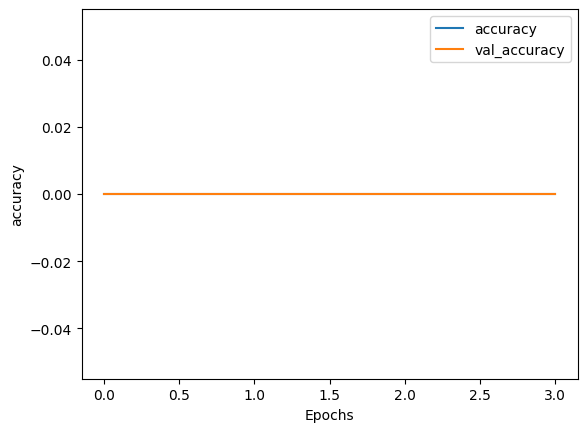

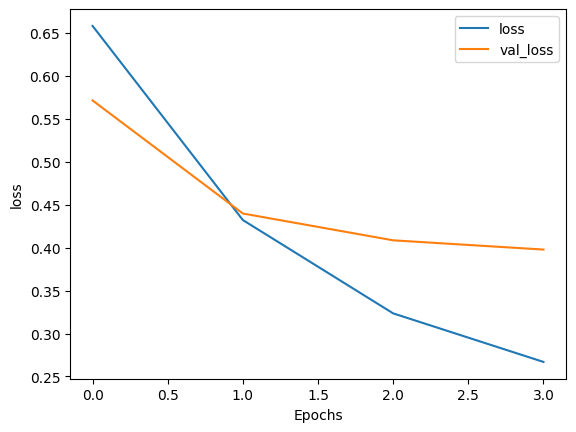

In [14]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and results
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")